In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms


# functions

In [ ]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [ ]:
def plot_performance(history,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(15,10))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(history['epochs'],history['val_loss'])
  axis[0].plot(history['epochs'],history['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(history['epochs'],history['val_acc'])
  axis[1].plot(history['epochs'],history['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Val", "Train"], loc='upper right')
  figure.tight_layout(pad=5.0)
  return

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Resnet18:
  def __init__(self,num_classes,gamma,step_size,model_name,loss=None):
    self.num_classes=num_classes
    self.gamma=gamma

    self.step_size=step_size
    self.model_name=model_name
    self.model = models.resnet18(pretrained=True)
    self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
    self.model = self.model.to(device)
    # Define the loss function and optimizer
    self.criterion = loss
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    self.lr_scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
  def train(self,batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader):
    history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
    for epoch in tqdm(range(1, epochs + 1)):
        top1_acc_train = AverageMeter()
        loss_avg_train = AverageMeter()
        top1_acc_val = AverageMeter()
        loss_avg_val = AverageMeter()
        self.model.train()
        mode = "train"
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True)
        temp1=0
        temp2=0
        counter=0
        for batch_idx, (images, labels) in loop_train:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.model(images)
            loss = self.criterion(labels_pred, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            acc1 = accuracy(labels_pred, labels)
            top1_acc_train.update(acc1[0], images.size(0))
            loss_avg_train.update(loss.item(), images.size(0))
            counter=counter+1
            temp1=temp1+loss_avg_train.avg
            temp2=temp2+top1_acc_train.avg

            #report.loc[len(report)] = new_row.values[0]

            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
                max_len=2,
                refresh=True,
            )
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{self.model_name}_epoch{epoch}.ckpt",
                model=self.model,
                optimizer=self.optimizer,
            )
        history["train_loss"].append(temp1/counter)
        history["train_acc"].append(temp2/counter)
        self.model.eval()
        mode = "val"
        with torch.no_grad():
            loop_val = tqdm(
                enumerate(val_loader, 1),
                total=len(val_loader),
                desc="val",
                position=0,
                leave=True,
            )
            temp1=0
            temp2=0
            counter=0
            for batch_idx, (images, labels) in loop_val:
                self.optimizer.zero_grad()
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred = self.model(images)
                loss = self.criterion(labels_pred, labels)
                acc1 = accuracy(labels_pred, labels)
                top1_acc_val.update(acc1[0], images.size(0))
                loss_avg_val.update(loss.item(), images.size(0))
                temp1=loss_avg_val.avg+temp1
                temp2=top1_acc_val.avg+temp2
                counter=counter+1

                #report.loc[len(report)] = new_row.values[0]
                loop_val.set_description(f"val - iteration : {epoch}")
                loop_val.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
                    top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
                    refresh=True,
                )
        history["val_loss"].append(temp1/counter)
        history["val_acc"].append(temp2/counter)
        history["epochs"].append(epoch)
        self.lr_scheduler.step()
    #report.to_csv(f"{report_path}/{self.model_name}_report.csv")
    return self.model,history
  def evaluate(self,testloader,datatype="test"):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    self.model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = self.model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the {self.model_name} on the {total} {datatype} images: {100 * correct // total} %')

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
RVF = transforms.RandomVerticalFlip()
NRM = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()

GB = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
CJ = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
RA = transforms.RandomAutocontrast()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
# , transform = transform_with_aug)
trainset = CIFAR10(root='./data', train=True, download=True)
# , transform = transform_no_aug)
testset = CIFAR10(root='./data', train=False, download=True)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

# Separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = trainset.targets
y_test = testset.targets

# Define a function to separate CIFAR classes by class index


def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:, 0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]

    return x_i


class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc=transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc

    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)

    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

# ================== Usage ================== #


# Let's choose cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
frog_less_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']),
         get_class_i(x_train, y_train, classDict['car']),
         get_class_i(x_train, y_train, classDict['bird']),
         get_class_i(x_train, y_train, classDict['cat']),
         get_class_i(x_train, y_train, classDict['deer']),
         get_class_i(x_train, y_train, classDict['dog']),
         get_class_i(x_train, y_train, classDict['horse']),
         get_class_i(x_train, y_train, classDict['ship']),
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
frog_less_testset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']),
         get_class_i(x_train, y_train, classDict['car']),
         get_class_i(x_train, y_train, classDict['bird']),
         get_class_i(x_train, y_train, classDict['cat']),
         get_class_i(x_train, y_train, classDict['deer']),
         get_class_i(x_train, y_train, classDict['dog']),
         get_class_i(x_train, y_train, classDict['horse']),
         get_class_i(x_train, y_train, classDict['ship']),
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_no_aug
    )


frog_trainset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['frog'])],
        transform_with_aug
    )
frog_testset = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['frog'])],
        transform_no_aug
    )

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader = DataLoader(
    frog_less_trainset, batch_size=64, shuffle=True, **kwargs)
testsetLoader = DataLoader(
    frog_less_testset, batch_size=64, shuffle=False, **kwargs)

frogtrainsetLoader = DataLoader(
    frog_trainset, batch_size=64, shuffle=True, **kwargs)
frogtestsetLoader = DataLoader(
    frog_testset, batch_size=64, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the ResNet18 model properties
import pandas as pd
import os
num_classes = 9
step_size=10
gamma=0.5
batch_size = 64
epochs = 200
learning_rate = 1e-3
ckpt_save_freq = 20
report = pd.DataFrame(columns=["model_name","mode","image_type","epoch","learning_rate","batch_size",
                               "batch_index","loss_batch","avg_train_loss_till_current_batch","avg_train_top1_acc_till_current_batch",
                               "avg_val_loss_till_current_batch","avg_val_top1_acc_till_current_batch"])
ckpt_save_path="./"
report_path="./"

In [ ]:
#define resnet
model_name="Resnet18_Without_Adv_training"
loss=nn.CrossEntropyLoss()
clean_resnet18=Resnet18(num_classes,gamma,step_size,model_name,loss)
clearn_model,history=clean_resnet18.train(batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,trainsetLoader,testsetLoader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 200/200 [3:08:03<00:00, 56.42s/it]


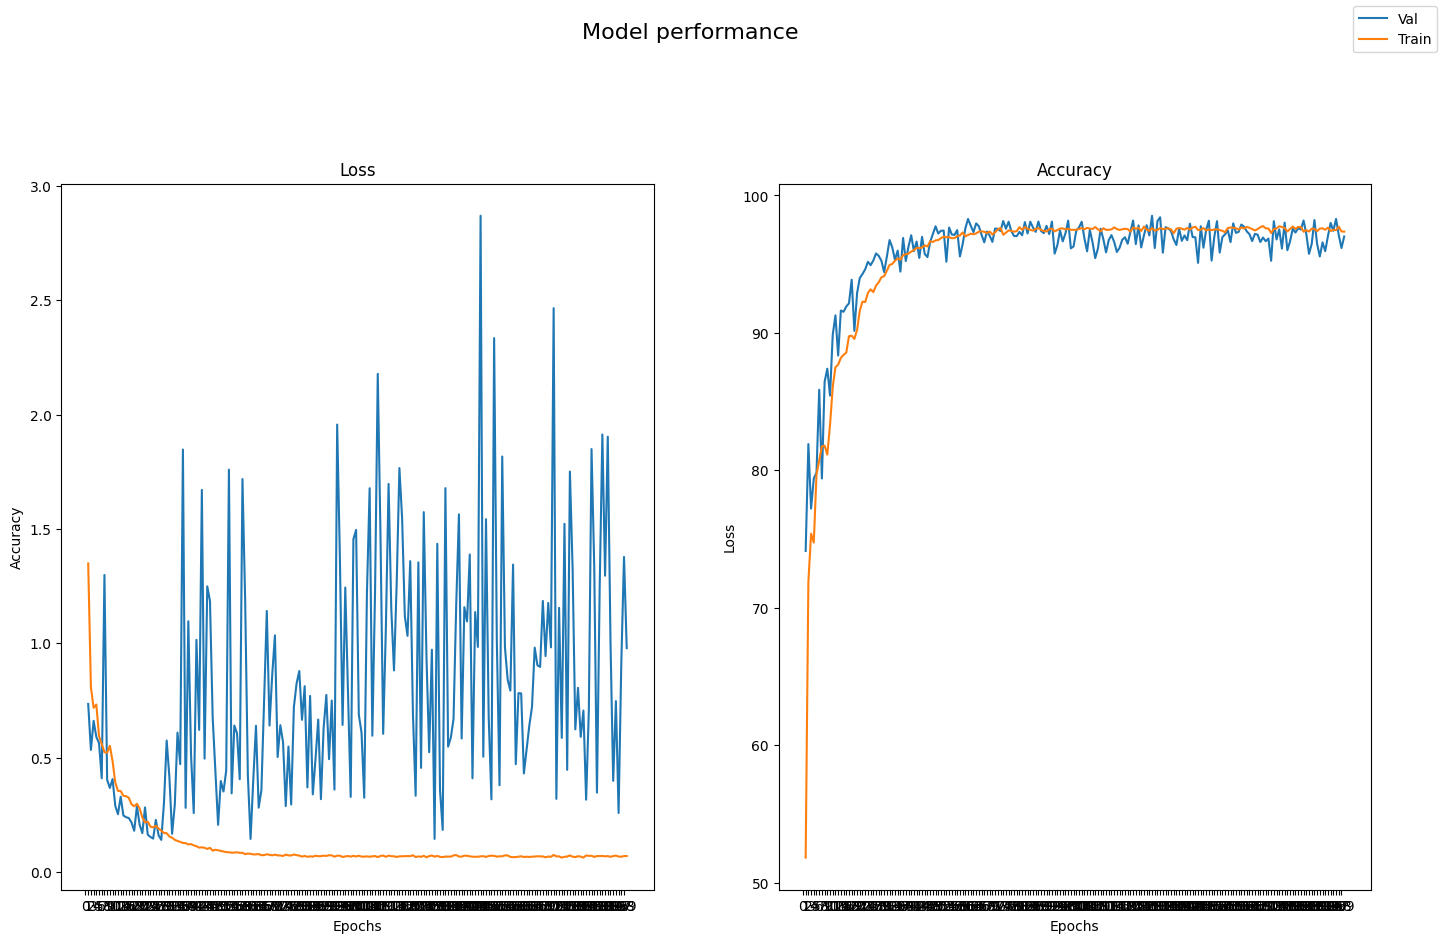

In [ ]:
import matplotlib.pyplot as plt
plot_performance(history)

In [ ]:
import json
with open('my_dict.json', 'w') as file:
    json.dump(history, file)

In [ ]:
total_count=0
ratio=0
threshold=.855
probs=[]
clearn_model.eval()
total_count=0
with torch.no_grad():
  for x ,y in testsetLoader:
    x = x.to(device)
    this= clearn_model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    probs.extend(max_prob.tolist())
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num > threshold)
    total_count=count+total_count
ratio=total_count/len(testsetLoader.dataset)

In [ ]:
ratio

0.9510444444444445

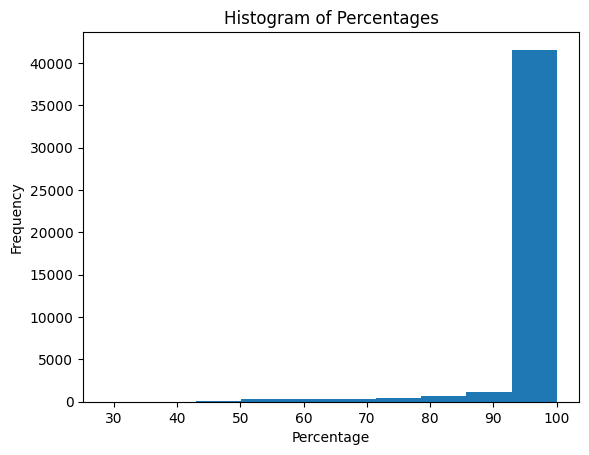

In [ ]:
import matplotlib.pyplot as plt

percentages = [prob * 100 for prob in probs]

# Create histogram
plt.hist(percentages, bins=10)
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Percentages')
plt.show()

In [ ]:
total_count=0
ratio=0
tresh=threshold
probs=[]
clearn_model.eval()
total_count=0
with torch.no_grad():
  for x ,y in frogtestsetLoader:
    x = x.to(device)
    this= clearn_model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    probs.extend(max_prob.tolist())
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num < tresh)
    total_count=count+total_count
ratio=total_count/len(frogtestsetLoader.dataset)

In [ ]:
ratio

0.3608

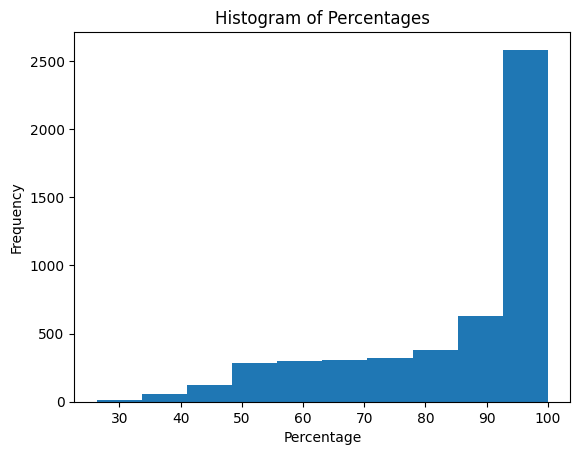

In [ ]:
import matplotlib.pyplot as plt

percentages = [prob * 100 for prob in probs]

# Create histogram
plt.hist(percentages, bins=10)
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Percentages')
plt.show()

# Cats


In [ ]:
model=models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 9)
clearn_model,idc=load_model("/content/drive/MyDrive/ModelsTAI/ckpt_Catlessmodel_epoch200.ckpt",model)

In [ ]:
total_count=0
ratio=0
threshold=.9
probs=[]
clearn_model.eval()
total_count=0
with torch.no_grad():
  for x ,y in catlesstestsetLoader:
    x = x.to(device)
    this= clearn_model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    probs.extend(max_prob.tolist())
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num >threshold)
    total_count=count+total_count


In [ ]:
ratio=total_count/len(catlesstestsetLoader.dataset)
print(ratio)

0.9430666666666667


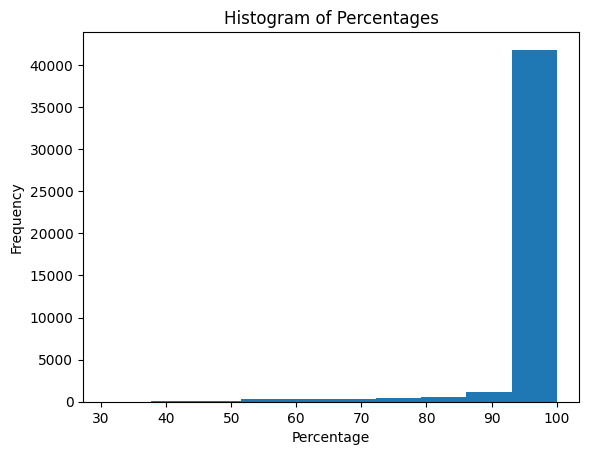

In [ ]:
import matplotlib.pyplot as plt

percentages = [prob * 100 for prob in probs]

# Create histogram
plt.hist(percentages, bins=10)
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Percentages')
plt.show()

In [ ]:
total_count=0
ratio=0
probs=[]
clearn_model.eval()
total_count=0
with torch.no_grad():
  for x ,y in cattestsetLoader:
    x = x.to(device)
    this= clearn_model(x)
    probabilities = nn.Softmax(dim=1)(this)
    max_prob, predicted = torch.max(probabilities, dim=1)
    probs.extend(max_prob.tolist())
    #max_prob, predicted = torch.max(this, dim=1)
    count = sum(1 for num in max_prob if num >threshold)
    total_count=count+total_count
ratio=total_count/len(cattestsetLoader.dataset)

In [ ]:
print(ratio)

0.567


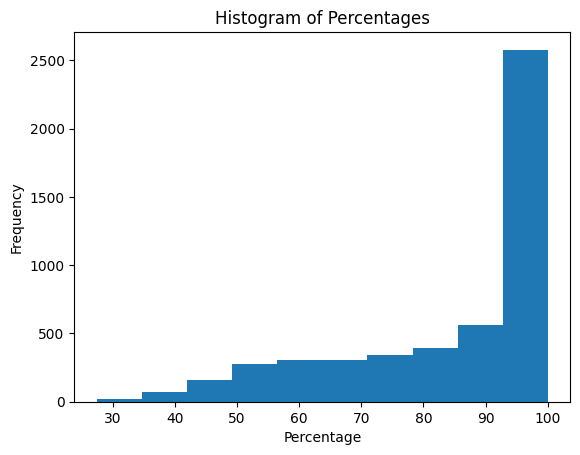

In [ ]:
import matplotlib.pyplot as plt

percentages = [prob * 100 for prob in probs]

# Create histogram
plt.hist(percentages, bins=10)
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Percentages')
plt.show()